In [25]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf

import IPython.display as display_obj
from random import randint

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools
import os

#  visualize the input

#### Define a function to load an image and limit its maximum dimension to 512 pixels.

In [26]:
def tensor_to_image(tensor):
  tensor_shape = tf.shape(tensor)
  number_elem_shape = tf.shape(tensor_shape)
  if number_elem_shape > 3:
    assert tensor_shape[0] == 1
    tensor = tensor[0]
  return tf.keras.preprocessing.image.array_to_img(tensor) 

### Load and preprocess the image

In [27]:
def load_img(path_to_img):
  max_dim = 512
  image = tf.io.read_file(path_to_img)
  image = tf.image.decode_jpeg(image)
  image = tf.image.convert_image_dtype(image, tf.float32)

  shape = tf.shape(image)[:-1]
  shape = tf.cast(tf.shape(image)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  image = tf.image.resize(image, new_shape)
  image = image[tf.newaxis, :]
  image = tf.image.convert_image_dtype(image, tf.uint8)
  return image

def preprocess_image(image):
    image = tf.cast(image, dtype=tf.float32)
    image = tf.keras.applications.vgg19.preprocess_input(image)

    return image


In [28]:
def load_img(path_to_img):
  max_dim = 512
  image = tf.io.read_file(path_to_img)
  image = tf.image.decode_jpeg(image)
  image = tf.image.convert_image_dtype(image, tf.float32)

  shape = tf.shape(image)[:-1]
  shape = tf.cast(tf.shape(image)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  image = tf.image.resize(image, new_shape)
  image = image[tf.newaxis, :]
  image = tf.image.convert_image_dtype(image, tf.uint8)
  return image

def preprocess_image(image):
    image = tf.cast(image, dtype=tf.float32)
    image = tf.keras.applications.vgg19.preprocess_input(image)

    return image


In [32]:
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)
    
    
def show_images_with_objects(images, titles=[]):

  if len(images) != len(titles):
    return

  plt.figure(figsize=(20, 12))
  for idx, (image, title) in enumerate(zip(images, titles)):
    plt.subplot(1, len(images), idx + 1)
    plt.xticks([])
    plt.yticks([])
    imshow(image, title)
    
    
def load_images(content_path, style_path):
  content_image = load_img("{}".format(content_path))
  style_image = load_img("{}".format(style_path))

  return content_image, style_image

## Build the model 

First, download the VGG19 model so that you can inspect the layers that are available for you to use.

In [5]:
tmp_vgg = tf.keras.applications.vgg19.VGG19()
tmp_vgg.summary()

A local file was found, but it seems to be incomplete or outdated because the auto file hash does not match the original value of cbe5617147190e668d6c5d5026f83318 so we will re-download the data.
574717952/574710816 [==============================] - 265s 0us/step
Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856

Choose intermediate layers from the network to represent the style and content of the image:

- For the content layer, please use the second convolutional layer of the last convolutional block (just one layer)
- For the style layers, please use the first layer of each convolutional block.

In [7]:
# Content layer where will pull our feature maps

# Fill in the list for content_layers
content_layers = ['block5_conv2'] 

# Style layer of interest
style_layers = ['block1_conv1', 
                'block2_conv1', 
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1'] 

# combine the two lists (put the style layers before the content layers)
output_layers = style_layers + content_layers 

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)
num_output_layers = len(output_layers)

Define your model to take the same input as the standard vgg19 model, and output just the selected content and style layers.

In [9]:
def vgg_model(layer_names):
  """ Creates a vgg model that returns a list of intermediate output values.
  
  args:
    layer_names: a list of strings, representing the names of the desired content and style layers
    
  returns:
    A model that takes the regular vgg19 input and outputs just the content and style layers.
  
  """

  # Load the the pretrained VGG, trained on imagenet data
  vgg = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet')

  # Freeze the weights of the model's layers (make them not trainable)
  vgg.trainable = False
  
  # Create a list of layer objects that are specified by layer_names
  outputs = [vgg.get_layer(name).output for name in layer_names]

  # Create the model that outputs content and style layers only
  model = tf.keras.Model(inputs=vgg.input, outputs=outputs)

  return model

Create an instance of the content and style model using the function that you just defined

In [11]:
vgg = vgg_model(output_layers) 

80142336/80134624 [==============================] - 33s 0us/step


### return style_loss
Calculate content loss
Calculate the content loss as the average squared difference between the features and targets.

In [12]:
def get_content_loss(features, targets):
  """Expects two images of dimension h, w, c
  args:
    features: tensor with shape: (height, width, channels)
    targets: tensor with shape: (height, width, channels)
  """
    
  # Calculate the style style loss
  content_loss = tf.reduce_mean(tf.square(features - targets)) # @REPLACE content_loss = None
    
  return content_loss

### Calculate the gram matrix

Use `tf.linalg.einsum` to calculate the gram matrix for an input tensor.
- In addition, calculate the scaling factor `num_locations` and divide the gram matrix calculation by `num_locations`.

$$ \text{num locations} = height \times width $$

In [13]:
def gram_matrix(input_tensor):
  """ Calculates the gram matrix and divides by the number of locations
  args:
    input_tensor: tensor of shape (batch, height, width, channels)
    
    
  return:
    scaled_gram: gram matrix divided by the number of locations
  """

  # Calculate the gram matrix of the input tensor
  gram = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor) 

  # get the height and width of the input tensor
  input_shape = tf.shape(input_tensor) 
  height = input_shape[1] 
  width = input_shape[2] 

  # Get the number of locations (height times width), and cast it as a tf.float32
  num_locations = tf.cast(height * width, tf.float32)

  # Scale the gram matrix by dividing by the number of locations
  scaled_gram = gram / num_locations
    
  # return the scaled gram matrix
  return scaled_gram

In [47]:
def get_style_loss(features, targets):
  """Expects two images of dimension h, w, c
  args:
    features: tensor with shape: (height, width, channels)
    targets: tensor with shape: (height, width, channels)
  """
    
  # Calculate the style style loss
  style_loss = tf.reduce_mean(tf.square(features - targets))
    
  return style_loss

## style image features

Given the style image as input, you'll get the style features of the custom vgg model that you just created using `vgg_model()`.
- You'll first preprocess the image using the given `preprocess_image` function.
- You'll then get the outputs of the vgg model.
- From the outputs, just get the style feature layers and not the content feature layer.

You can run the following code to check the order of the layers in your custom vgg model:

In [14]:
tmp_layer_list = [layer.output for layer in vgg.layers]
tmp_layer_list

[<tf.Tensor 'input_2:0' shape=(None, None, None, 3) dtype=float32>,
 <tf.Tensor 'block1_conv1_1/Identity:0' shape=(None, None, None, 64) dtype=float32>,
 <tf.Tensor 'block1_conv2_1/Identity:0' shape=(None, None, None, 64) dtype=float32>,
 <tf.Tensor 'block1_pool_1/Identity:0' shape=(None, None, None, 64) dtype=float32>,
 <tf.Tensor 'block2_conv1_1/Identity:0' shape=(None, None, None, 128) dtype=float32>,
 <tf.Tensor 'block2_conv2_1/Identity:0' shape=(None, None, None, 128) dtype=float32>,
 <tf.Tensor 'block2_pool_1/Identity:0' shape=(None, None, None, 128) dtype=float32>,
 <tf.Tensor 'block3_conv1_1/Identity:0' shape=(None, None, None, 256) dtype=float32>,
 <tf.Tensor 'block3_conv2_1/Identity:0' shape=(None, None, None, 256) dtype=float32>,
 <tf.Tensor 'block3_conv3_1/Identity:0' shape=(None, None, None, 256) dtype=float32>,
 <tf.Tensor 'block3_conv4_1/Identity:0' shape=(None, None, None, 256) dtype=float32>,
 <tf.Tensor 'block3_pool_1/Identity:0' shape=(None, None, None, 256) dtype=fl

- For each style layer, calculate the gram matrix.  Store these results in a list and return it.

In [16]:
def get_style_image_features(image):  
  """ Get the style image features
  
  args:
    image: an input image
    
  return:
    gram_style_features: the style features as gram matrices
  """
  # preprocess the image using the given preprocessing function
  preprocessed_style_image = preprocess_image(image) 

  # get the outputs from the custom vgg model that you created using vgg_model()
  outputs = vgg(preprocessed_style_image) 

  # Get just the style feature layers (exclude the content layer)
  style_outputs = outputs[:num_style_layers] 

  # for each style layer, calculate the gram matrix for that layer and store these results in a list
  gram_style_features = [gram_matrix(style_layer) for style_layer in style_outputs] 

  return gram_style_features

### Get content image features

Given the content image as input, you'll get the style features (not the content features) of the content image.
- You can follow a similar process as you did with `get_style_image_features`.
- For the content image, you will not calculate the gram matrix of these style features.

In [17]:
def get_content_image_features(image):

  # preprocess the image
  preprocessed_content_image = preprocess_image(image)
    
  # get the outputs from the vgg model
  outputs = vgg(preprocessed_content_image) 

  # get the style layers of the outputs (excluding the content layer output)
  style_outputs = outputs[num_style_layers:]

  # return the style layer outputs of the content image
  return style_outputs

In [18]:
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [19]:
def calculate_gradients(image, content_targets, style_targets, style_weight, content_weight):
    total_variation_weight = 30

    with tf.GradientTape() as tape:

      # scale up the image from [0 to 1] to [0 to 255] by multiplying by 255
      image = image * 255 
        
      # get the style image features
      style_features = get_style_image_features(image) 
        
      # get the content image features
      content_features = get_content_image_features(image) 
        
      # get the style and content loss
      loss = get_style_content_loss(style_targets, style_features, content_targets, content_features, style_weight, content_weight) 

    # calculate gradients of loss with respect to the image
    gradients = tape.gradient(loss, image) 

    # return gradients
    return gradients

In [20]:
def update_image_with_style(image, content_targets, style_targets, optimizer, style_weight, content_weight):

  # Calculate gradients using the function that you just defined.
  gradients = calculate_gradients(image, content_targets, style_targets, style_weight, content_weight) 

  # apply the gradients to the given image
  optimizer.apply_gradients([(gradients, image)]) 

  # Clip the image using the given clip_0_1() function
  image.assign(clip_0_1(image))

In [42]:
def get_style_content_loss(style_targets, style_outputs, content_targets, content_outputs, style_weight, content_weight):
    
  # Sum of the style losses
  style_loss = tf.add_n([ get_style_loss(style_output, style_target)
                           for style_output, style_target in zip(style_outputs, style_targets)])
  
  # Sum up the content losses
  content_loss = tf.add_n([get_content_loss(content_output, content_target)
                           for content_output, content_target in zip(content_outputs, content_targets)])

  # scale the style loss by multiplying by the style weight and dividing by the number of style layers
  style_loss = style_loss * style_weight / num_style_layers 

  # scale the content loss by multiplying by the content weight and dividing by the number of content layers
  content_loss =content_loss * content_weight / num_content_layers 
    
  # sum up the style and content losses
  total_loss = style_loss + content_loss 

  # return the total loss
  return total_loss

## Train Model

In [22]:
def fit_style_transfer(input_image, style_image, optimizer, epochs=1, steps_per_epoch=1, style_weight = 0.01, with_regularization=False):

  images = []
  import time
  start = time.time()

  step = 0

  #style_weight=1.0
  content_weight=1e2

  # get the style image features 
  style_targets = get_style_image_features(style_image)
    
  # get the content image features
  content_targets = get_content_image_features(input_image)


  input_image = tf.image.convert_image_dtype(input_image, dtype=tf.float32)
  
  input_image = tf.Variable(input_image) 
  images.append(tf.Variable(input_image)) 
  
  for n in range(epochs):
    for m in range(steps_per_epoch):
      step += 1
    
      # Update the image with the style using the function that you defined
      update_image_with_style(input_image, content_targets, style_targets, optimizer, style_weight, content_weight) 
    

      print(".", end='')
      if (m + 1) % 10 == 0:
        images.append(tf.Variable(input_image))
    
    display_obj.clear_output(wait=True)
    display_image = tensor_to_image(input_image)

    
    display_obj.display(display_image)
    images.append(tf.Variable(input_image))
    print("Train step: {}".format(step))
  end = time.time()
  print("Total time: {:.1f}".format(end-start)) 
  
  return input_image, images

## Load some images to try it out!

In [40]:
content_image, style_image = load_images("mkt.jpeg", "mkt2.jpg")

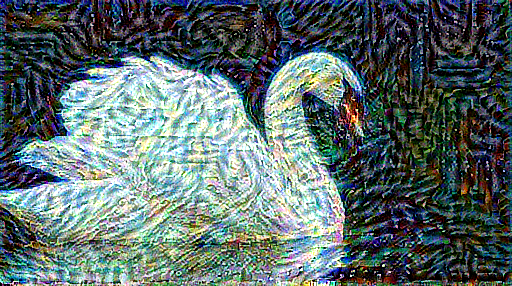

Train step: 100
...................

In [ ]:
weight =  0.01 
adam = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)
stylized_image, display_images = fit_style_transfer(input_image=content_image, style_image=style_image, optimizer=adam, epochs=10, steps_per_epoch=100, style_weight=weight)

In [44]:
# Display Utilities

import imageio
from IPython.display import display as display_fn
from IPython.display import Image

def display_gif(GIF_PATH):
  with open(GIF_PATH,'rb') as f:
    display_fn(Image(data=f.read(), format='png'))

def create_gif(images):
  GIF_PATH = "/content/{}.gif".format(randint(0, 10000))
  imageio.mimsave(GIF_PATH, images, fps=1)
  return GIF_PATH


In [ ]:
# Display GIF of Intermedite Outputs
gif_images = [np.squeeze(image.numpy(), axis=0) for image in display_images]
gif_path = create_gif(gif_images)

In [ ]:
display_gif(gif_path)